# Analyse ciblée — Santé, Longévité et IDH

Notebook centré sur 3 questions :

1. **La longévité est-elle toujours synonyme de bien‑être ?**
2. **Quels sont les principaux freins sanitaires à un IDH élevé ?**
3. **Les progrès sanitaires sont‑ils homogènes entre pays ?**

Ce notebook utilise le modèle de données en étoile (tables de faits et de dimensions) que vous avez pré‑établi (`fact_sante`, `dim_pays`, `dim_temps`, `dim_socio` ou équivalentes). Les cellules ci‑dessous adaptent automatiquement les jointures si nécessaire.


In [34]:
# imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


In [35]:
df_2 = pd.read_csv("Life_Expectancy_Clean.csv")

## Création d'une mesure de bien etre IDH

In [36]:
# === Vérification des colonnes ===
print(df_2.columns)

# === Calcul des sous-indices ===
df_2['indice_sante'] = (df_2['esperance_vie'] - 20) / (85 - 20)
df_2['indice_education'] = df_2['annees_scolarisation'] / 15

# on a deja  l'indice_revenu, on le borne seulement
df_2['indice_revenu'] = df_2['indice_revenu'].clip(0, 1)

# === Calcul de l’IDH (moyenne géométrique) ===
df_2['IDH'] = (df_2['indice_sante'] * df_2['indice_education'] * df_2['indice_revenu']) ** (1/3)

# === Vérification du résultat ===
print(" Colonne 'IDH' ajoutée avec succès à df_2 !\n")
display(df_2[['pays', 'indice_sante', 'indice_education', 'indice_revenu', 'IDH']].head())

# === Statistiques descriptives de l’IDH ===
print("\n Statistiques descriptives de l’IDH :")
print(df_2['IDH'].describe().round(3))


Index(['pays', 'annee', 'statut', 'esperance_vie', 'mortalite_adulte',
       'deces_nourrissons', 'consommation_alcool',
       'depenses_sante_pourcentage', 'vaccination_hepatite_b', 'cas_rougeole',
       'imc', 'deces_moins_5_ans', 'vaccination_polio',
       'depenses_sante_totales', 'vaccination_diphterie', 'mortalite_vih_sida',
       'pib_habitant', 'population', 'maigreur_1_19_ans', 'maigreur_5_9_ans',
       'indice_revenu', 'annees_scolarisation'],
      dtype='object')
 Colonne 'IDH' ajoutée avec succès à df_2 !



,pays,indice_sante,indice_education,indice_revenu,IDH
0,Afghanistan,0.692308,0.673333,0.479,0.606673
1,Afghanistan,0.613846,0.666667,0.476,0.579685
2,Afghanistan,0.613846,0.660000,0.470,0.575308
3,Afghanistan,0.607692,0.653333,0.463,0.568591
4,Afghanistan,0.603077,0.633333,0.454,0.557640



 Statistiques descriptives de l’IDH :
count    2928.000
mean        0.706
std         0.219
min         0.000
25%         0.590
50%         0.759
75%         0.845
max         1.089
Name: IDH, dtype: float64


## Creation d'une mesure de bien etre

In [37]:
from sklearn.preprocessing import MinMaxScaler

# Variables positives : plus elles augmentent, plus le bien-être augmente
positives = [
    'esperance_vie',
    'imc',
    'annees_scolarisation',
    'indice_revenu',
    'depenses_sante_pourcentage'
]

# Variables négatives : plus elles augmentent, plus le bien-être diminue
negatives = [
    'maigreur_1_19_ans',
    'maigreur_5_9_ans'
]

# Sélection des variables présentes dans ton dataframe
positives = [v for v in positives if v in df_2.columns]
negatives = [v for v in negatives if v in df_2.columns]

# Normalisation entre 0 et 1
scaler = MinMaxScaler()
df_norm = df_2.copy()
df_norm[positives + negatives] = scaler.fit_transform(df_norm[positives + negatives])

# Inversion des scores pour les variables négatives
for var in negatives:
    df_norm[var] = 1 - df_norm[var]

# Calcul final du bien-être (moyenne des dimensions)
df_2['bien_etre'] = df_norm[positives + negatives].mean(axis=1)


## Organisation géographique 

In [38]:
# Dictionnaire de correction pour les noms non reconnus
corrections_pays = {
    "Congo (Democratic Republic)": "Democratic Republic of the Congo",
    "Congo (Republic)": "Republic of the Congo",
    "South Sudan": "Sudan",
    "Palestine": "Israel",
    "Kosovo": "Serbia",
    "Micronesia (Federated States of)": "Micronesia",
    "Lao People's Democratic Republic": "Laos",
    "Viet Nam": "Vietnam",
    "Syrian Arab Republic": "Syria",
    "Iran (Islamic Republic of)": "Iran",
    "United States of America": "United States",
    "Republic of Korea": "South Korea",
    "Democratic People's Republic of Korea": "North Korea",
    "Bolivia (Plurinational State of)": "Bolivia",
    "Burma": "Myanmar",
    "The former Yugoslav republic of Macedonia": "North Macedonia",
    "Venezuela (Bolivarian Republic of)": "Venezuela",
    "East Timor": "Timor-Leste"
}






In [39]:

import pycountry_convert as pc

def get_continent(country_name):
    try:
        country_code = pc.country_name_to_country_alpha2(country_name, cn_name_format="default")
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_dict = {
            "AF": "Afrique",
            "AS": "Asie",
            "EU": "Europe",
            "NA": "Amérique du Nord",
            "SA": "Amérique du Sud",
            "OC": "Océanie"
        }
        return continent_dict.get(continent_code, "Autre")
    except:
        return "Autre"
df_2["pays"] = df_2["pays"].replace(corrections_pays)
df_2["continent"] = df_2["pays"].apply(get_continent)
# Liste des pays restants dans "Autre"
autres_pays = df_2.loc[df_2["continent"] == "Autre", "pays"].unique()
print(f"Pays encore non reconnus ({len(autres_pays)}) :")
print(autres_pays)



# Calcul de la moyenne de l’IDH par continent et par année
idh_continent = (
    df_2.groupby(["annee", "continent"])["IDH"]
    .mean()
    .reset_index()
)




Pays encore non reconnus (1) :
['Timor-Leste']


In [40]:
# Version analytique complète
df_2.to_csv("data/Life_expectency_complete.csv", index=False)

# Version simplifiée pour le dashboard
cols_dashboard = ['pays', 'annee', 'statut', 'continent', 'esperance_vie',
                  'mortalite_adulte', 'IDH', 'bien_etre']
df_dash = df_2[cols_dashboard]
df_dash.to_csv("data/Life_expectency_dashboard.csv", index=False)


## Modelisation de données

In [41]:
# ==============================================================
#    MODELE EN ETOILE — AVEC LES NOUVEAUX INDICATEURS (IDH & BIEN-ÊTRE)
# ==============================================================

# ---------------------------
#  Dimension PAYS
# ---------------------------
dim_pays = (
    df_2[['pays', 'statut', 'continent', 'population']]
    .drop_duplicates()
    .reset_index(drop=True)
)
dim_pays['id_pays'] = dim_pays.index + 1


# ---------------------------
#  Dimension ANNEE
# ---------------------------
dim_annee = (
    df_2[['annee']]
    .drop_duplicates()
    .sort_values('annee')
    .reset_index(drop=True)
)
dim_annee['id_annee'] = dim_annee.index + 1


# ---------------------------
#  Dimension SOCIO-ÉCONOMIQUE
# ---------------------------
dim_socio = (
    df_2[[
        'indice_revenu', 
        'annees_scolarisation', 
        'consommation_alcool',
        'depenses_sante_pourcentage',
        'pib_habitant'
    ]]
    .drop_duplicates()
    .reset_index(drop=True)
)
dim_socio['id_socio'] = dim_socio.index + 1


# ---------------------------
#  Dimension SANTÉ & MODE DE VIE
# ---------------------------
dim_sante = (
    df_2[[
        'imc', 
        'maigreur_1_19_ans', 
        'maigreur_5_9_ans',
        'vaccination_hepatite_b', 
        'vaccination_polio',
        'vaccination_diphterie',
        'cas_rougeole'
    ]]
    .drop_duplicates()
    .reset_index(drop=True)
)
dim_sante['id_sante'] = dim_sante.index + 1


# ---------------------------
#  Table de FAITS : FAITS_SANTE
# ---------------------------
faits_sante = (
    df_2
    .merge(dim_pays, on=['pays', 'statut', 'continent', 'population'], how='left')
    .merge(dim_annee, on='annee', how='left')
    .merge(dim_socio, on=['indice_revenu', 'annees_scolarisation', 'consommation_alcool',
                          'depenses_sante_pourcentage', 'pib_habitant'], how='left')
    .merge(dim_sante, on=['imc', 'maigreur_1_19_ans', 'maigreur_5_9_ans',
                          'vaccination_hepatite_b', 'vaccination_polio',
                          'vaccination_diphterie', 'cas_rougeole'], how='left')
)

# On garde uniquement les colonnes utiles pour la table de faits
faits_sante = faits_sante[[
    'id_pays', 'id_annee', 'id_socio', 'id_sante',
    'esperance_vie', 'mortalite_adulte', 'deces_nourrissons', 
    'deces_moins_5_ans', 'mortalite_vih_sida',
    'depenses_sante_totales', 'IDH', 'bien_etre'
]]

# Ajout d’un ID unique pour chaque ligne de faits
faits_sante.reset_index(inplace=True)
faits_sante.rename(columns={'index': 'id_fait'}, inplace=True)


# ---------------------------
#  Sauvegarde locale
# ---------------------------
dim_pays.to_csv('Dim_Pays.csv', index=False)
dim_annee.to_csv('Dim_Annee.csv', index=False)
dim_socio.to_csv('Dim_SocioEconomique.csv', index=False)
dim_sante.to_csv('Dim_Sante.csv', index=False)
faits_sante.to_csv('Faits_Sante.csv', index=False)

print("Tables créées et sauvegardées avec succès !")
print(f"Dimensions : PAYS ({dim_pays.shape}), ANNEE ({dim_annee.shape}), SOCIO-ÉCONOMIQUE ({dim_socio.shape}), SANTÉ ({dim_sante.shape})")
print(f"Table de FAITS : ({faits_sante.shape})")


Tables créées et sauvegardées avec succès !
Dimensions : PAYS ((2320, 5)), ANNEE ((16, 2)), SOCIO-ÉCONOMIQUE ((2879, 6)), SANTÉ ((2918, 8))
Table de FAITS : ((2928, 13))


In [42]:
# Helper pour charger une variable depuis l'environnement si présente, sinon depuis CSV, sinon construire depuis df_2
def load_table(var_name, csv_name=None, constructor=None):
    # 1) si variable existe globalement (rare dans un notebook autonome), on la prend
    if var_name in globals():
        return globals()[var_name]
    # 2) sinon essayer de charger un csv fourni
    if csv_name is not None:
        try:
            df = pd.read_csv(csv_name)
            print(f"Loaded {csv_name}")
            return df
        except Exception:
            pass
    # 3) fallback : construire via constructor si df_2 est présent
    if constructor is not None:
        try:
            return constructor()
        except Exception as e:
            print(f"Impossible de construire {var_name}: {e}")
    raise FileNotFoundError(f"Table {var_name} introuvable. Fournir la variable, un CSV ou assurez-vous que df_2 est chargé.")

# Constructeurs par défaut (utilisent df_2)
def construct_fact_sante():
    cols = ['pays', 'annee', 'esperance_vie', 'mortalite_adulte', 'deces_nourrissons',
            'deces_moins_5_ans', 'mortalite_vih_sida', 'IDH']
    available = [c for c in cols if c in df_2.columns]
    fact = df_2[['pays','annee'] + available].copy()
    # créer des ids si besoin
    fact = fact.reset_index(drop=True)
    fact['pays_id'] = fact['pays'].astype('category').cat.codes + 1
    fact['annee_id'] = fact['annee']
    return fact

def construct_dim_pays():
    if 'pays' not in df_2.columns:
        raise ValueError('La colonne "pays" est absente de df_2.')
    dim = df_2[['pays','statut','continent','population']].drop_duplicates().reset_index(drop=True)
    dim['pays_id'] = dim.index + 1
    return dim

def construct_dim_temps():
    if 'annee' not in df_2.columns:
        raise ValueError('La colonne "annee" est absente de df_2.')
    dimt = df_2[['annee']].drop_duplicates().sort_values('annee').reset_index(drop=True)
    dimt['annee_id'] = dimt['annee']
    return dimt

def construct_dim_socio():
    cols = [c for c in ['pib_habitant','annees_scolarisation','indice_revenu'] if c in df_2.columns]
    dim = df_2[['pays'] + cols].drop_duplicates().reset_index(drop=True)
    dim['pays_id'] = dim['pays'].astype('category').cat.codes + 1
    return dim

# Charger/Construire les tables
faits_sante = load_table('faits_sante', csv_name='faits_Sante.csv', constructor=construct_fact_sante)
dim_pays = load_table('Dim_pays', csv_name='Dim_Pays.csv', constructor=construct_dim_pays)
dim_temps = load_table('Dim_temps', csv_name='Dim_Années.csv', constructor=construct_dim_temps)
dim_socio = load_table('Dim_socio', csv_name='Dim_Socioeconomique.csv', constructor=construct_dim_socio)

print('Tables prêtes :', 'faits_sante' in globals(), 'dim_pays' in globals(), 'dim_temps' in globals(), 'dim_socio' in globals())
display(faits_sante.head())
display(dim_pays.head())
display(dim_temps.head())


Loaded Dim_Pays.csv
Loaded Dim_Socioeconomique.csv
Tables prêtes : True True True True


,id_fait,id_pays,id_annee,id_socio,id_sante,esperance_vie,mortalite_adulte,deces_nourrissons,deces_moins_5_ans,mortalite_vih_sida,depenses_sante_totales,IDH,bien_etre
0,0,1,16,1,1,65.0,263.0,62,83,0.1,8.16,0.606673,0.364952
1,1,2,15,2,2,59.9,271.0,64,86,0.1,8.18,0.579685,0.346514
2,2,3,14,3,3,59.9,268.0,66,89,0.1,8.13,0.575308,0.341947
3,3,4,13,4,4,59.5,272.0,69,93,0.1,8.52,0.568591,0.335683
4,4,5,12,5,5,59.2,275.0,71,97,0.1,7.87,0.557640,0.327620


,pays,statut,continent,population,id_pays
0,Afghanistan,Developing,Asie,33736494,1
1,Afghanistan,Developing,Asie,327582,2
2,Afghanistan,Developing,Asie,31731688,3
3,Afghanistan,Developing,Asie,3696958,4
4,Afghanistan,Developing,Asie,2978599,5


,annee,annee_id
0,2000,2000
1,2001,2001
2,2002,2002
3,2003,2003
4,2004,2004


 Matrice de corrélation :


,esperance_vie,mortalite_adulte,deces_nourrissons,deces_moins_5_ans,mortalite_vih_sida,vaccination_hepatite_b,vaccination_polio,vaccination_diphterie,cas_rougeole,pib_habitant,depenses_sante_totales,depenses_sante_pourcentage,imc,maigreur_1_19_ans,maigreur_5_9_ans,indice_revenu,annees_scolarisation,IDH
esperance_vie,1.000,-0.696,-0.197,-0.223,-0.557,0.332,0.460,0.475,-0.158,0.432,0.210,0.382,0.559,-0.468,-0.462,0.689,0.717,0.705
mortalite_adulte,-0.696,1.000,0.079,0.094,0.524,-0.193,-0.274,-0.275,0.031,-0.282,-0.112,-0.243,-0.381,0.296,0.302,-0.436,-0.436,-0.450
deces_nourrissons,-0.197,0.079,1.000,0.997,0.025,-0.224,-0.167,-0.172,0.501,-0.103,-0.126,-0.086,-0.227,0.465,0.470,-0.141,-0.192,-0.145
deces_moins_5_ans,-0.223,0.094,0.997,1.000,0.038,-0.235,-0.185,-0.192,0.508,-0.106,-0.128,-0.088,-0.237,0.467,0.471,-0.159,-0.208,-0.163
mortalite_vih_sida,-0.557,0.524,0.025,0.038,1.000,-0.133,-0.156,-0.162,0.031,-0.123,0.001,-0.098,-0.243,0.203,0.206,-0.248,-0.221,-0.265
vaccination_hepatite_b,0.332,-0.193,-0.224,-0.235,-0.133,1.000,0.491,0.589,-0.156,0.081,0.113,0.034,0.217,-0.174,-0.186,0.280,0.301,0.295
vaccination_polio,0.460,-0.274,-0.167,-0.185,-0.156,0.491,1.000,0.680,-0.133,0.195,0.131,0.149,0.276,-0.214,-0.215,0.372,0.407,0.379
vaccination_diphterie,0.475,-0.275,-0.172,-0.192,-0.162,0.589,0.680,1.000,-0.138,0.187,0.146,0.145,0.275,-0.221,-0.214,0.387,0.412,0.399
cas_rougeole,-0.158,0.031,0.501,0.508,0.031,-0.156,-0.133,-0.138,1.000,-0.070,-0.104,-0.057,-0.176,0.225,0.221,-0.111,-0.122,-0.121
pib_habitant,0.432,-0.282,-0.103,-0.106,-0.123,0.081,0.195,0.187,-0.070,1.000,0.114,0.902,0.277,-0.265,-0.269,0.436,0.434,0.406


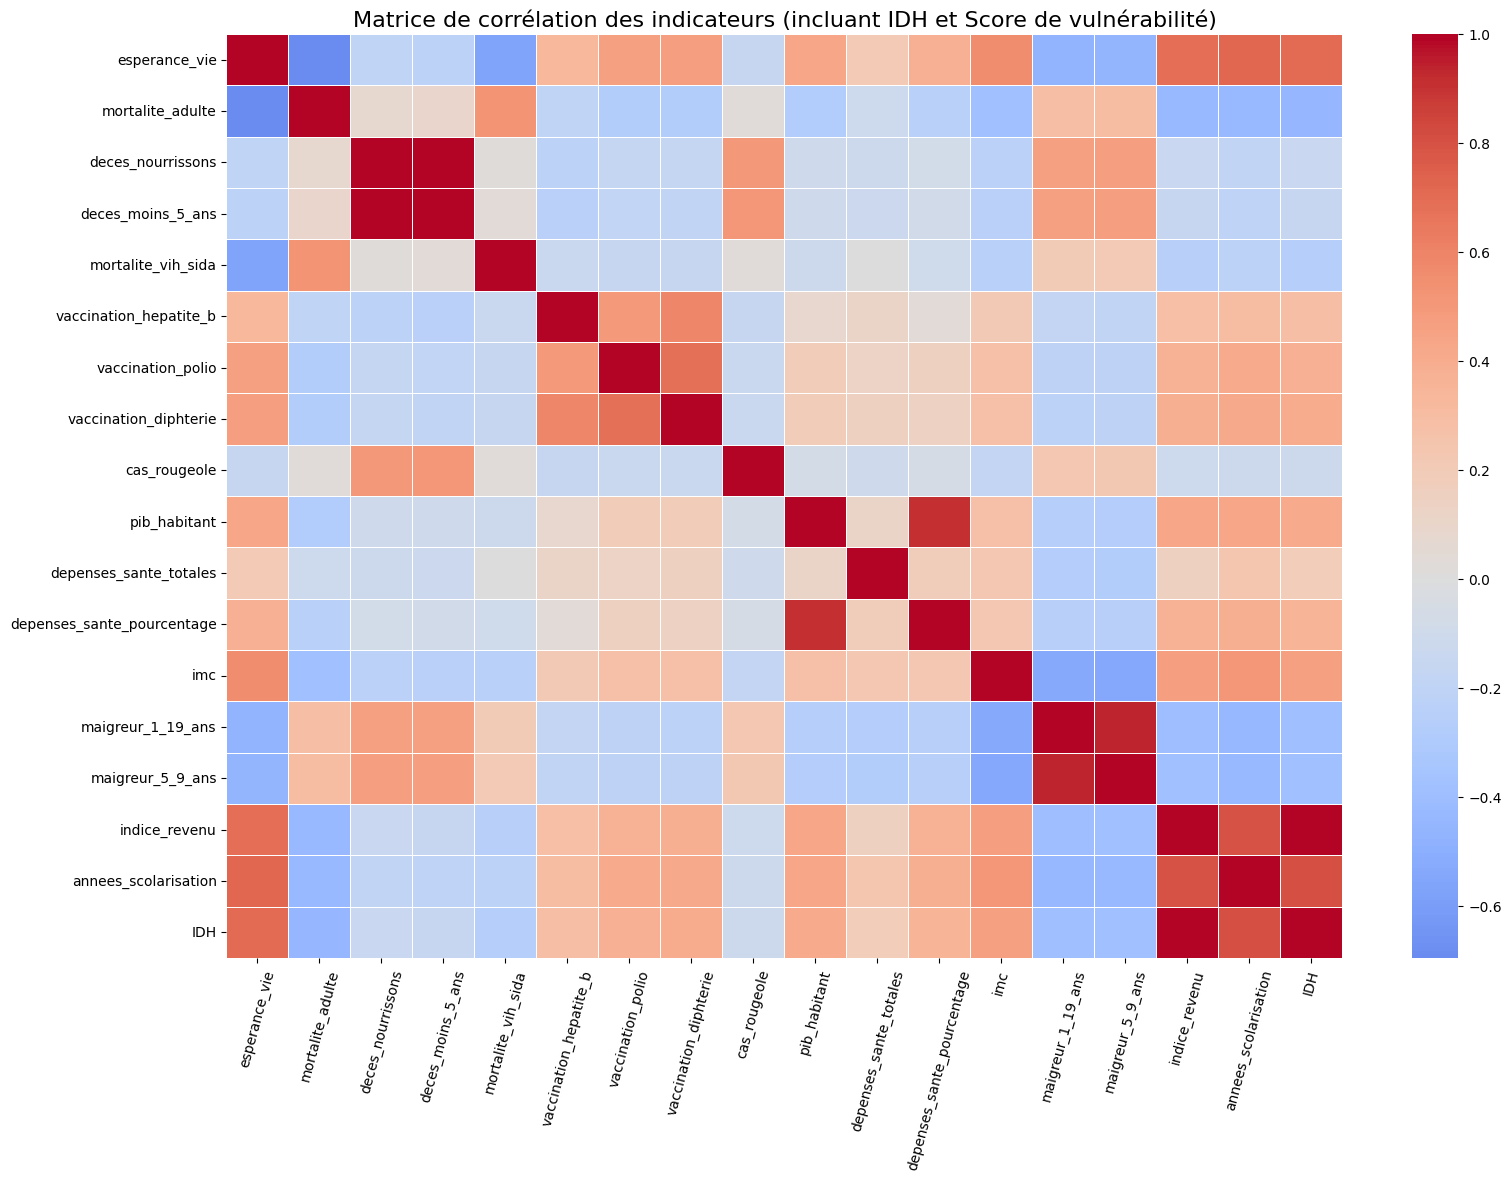

In [43]:
# =====================================================
# MATRICE DE CORRÉLATION (indicateurs + IDH + vuln_score)
# =====================================================

# Sélection des colonnes numériques pertinentes
numerical_cols = [
    'esperance_vie', 'mortalite_adulte', 'deces_nourrissons',
    'deces_moins_5_ans', 'mortalite_vih_sida', 'vaccination_hepatite_b',
    'vaccination_polio', 'vaccination_diphterie', 'cas_rougeole',
    'pib_habitant', 'depenses_sante_totales', 'depenses_sante_pourcentage',
    'imc', 'maigreur_1_19_ans', 'maigreur_5_9_ans', 
    'indice_revenu', 'annees_scolarisation', 'IDH', 'vuln_score'
]

# Filtrer seulement les colonnes présentes dans df_analysis
num_cols_available = [col for col in numerical_cols if col in df_2.columns]

# Calcul de la matrice
corr_matrix = df_2[num_cols_available].corr().round(3)

# Affichage tableau
print(" Matrice de corrélation :")
display(corr_matrix)

# =====================================================
# HEATMAP
# =====================================================
plt.figure(figsize=(18,12))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap='coolwarm',
    center=0,
    linewidths=.5
)
plt.title("Matrice de corrélation des indicateurs (incluant IDH et Score de vulnérabilité)", fontsize=16)
plt.xticks(rotation=75)
plt.yticks(rotation=0)
plt.show()


## 1) La longévité est‑elle toujours synonyme de bien‑être ?

Approche : joindre la table de faits `fact_sante` avec `dim_pays` pour récupérer le statut/continent, calculer la corrélation espérance de vie ↔ IDH, et visualiser via scatterplot + régression par statut.

Corrélation entre espérance de vie et IDH : 0.705


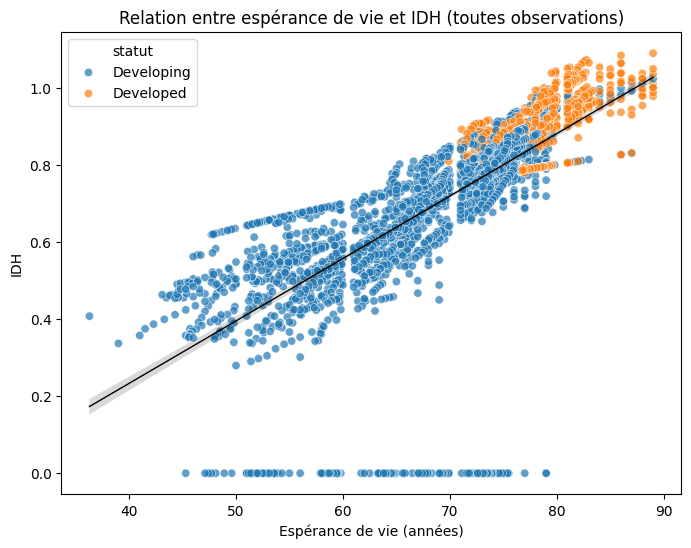

,pays,id_annee,esperance_vie,IDH,statut,continent


In [44]:
# Jointure pour analyse
df_analysis = faits_sante.merge(dim_pays[['pays','id_pays','statut','continent']], on='id_pays', how='left')
# S'assurer d'avoir IDH et esperance_vie
cols_needed = ['esperance_vie','IDH']
for c in cols_needed:
    if c not in df_analysis.columns:
        raise KeyError(f"Colonne manquante pour l'analyse: {c}")
# Corrélation
corr_ev_idh = df_analysis['esperance_vie'].corr(df_analysis['IDH'])
print(f"Corrélation entre espérance de vie et IDH : {corr_ev_idh:.3f}")

# Scatter + regression par statut
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_analysis, x='esperance_vie', y='IDH', hue='statut', alpha=0.7)
sns.regplot(data=df_analysis, x='esperance_vie', y='IDH', scatter=False, color='black', line_kws={'linewidth':1})
plt.title('Relation entre espérance de vie et IDH (toutes observations)')
plt.xlabel('Espérance de vie (années)')
plt.ylabel('IDH')
plt.show()

# Afficher exceptions : pays avec espérance élevée mais IDH faible (outliers à examiner)
anomalies = df_analysis[(df_analysis['esperance_vie'] >= df_analysis['esperance_vie'].quantile(0.9)) & (df_analysis['IDH'] <= df_analysis['IDH'].quantile(0.25))]
display(anomalies[['pays','id_annee','esperance_vie','IDH','statut','continent']].drop_duplicates().head(10))


## Graphique — Relation entre espérance de vie et IDH (toutes observations)

Ce graphique représente un nuage de points montrant la relation entre l’espérance de vie (en années) et l’IDH (Indice de Développement Humain), différenciée selon le statut des pays : *Developing* (en bleu) et *Developed* (en orange). Une ligne de régression est tracée pour illustrer la tendance générale.

###  Interprétation

On observe une forte relation positive entre l’espérance de vie et l’IDH : plus l’espérance de vie est élevée, plus l’IDH tend à être élevé. Cette corrélation est visible à travers la densité des points alignés le long de la droite de régression.

Les pays développés (en orange) se situent majoritairement dans la zone supérieure droite, ce qui confirme un niveau élevé simultanément en espérance de vie et en IDH. À l’inverse, les pays en développement (en bleu) forment un nuage étendu et dispersé dans la zone inférieure gauche, traduisant une plus grande hétérogénéité interne et une relation moins stable.

Ce graphique met en évidence :

-  une corrélation positive forte entre les deux variables  
-  une nette séparation entre pays développés et pays en développement  
-  la présence de quelques anomalies ou valeurs extrêmes parmi les pays en développement  
-  une relation cohérente avec les travaux empiriques montrant que l’amélioration des conditions de vie, de santé et d’éducation contribue fortement à l’IDH  

En résumé, l’espérance de vie constitue un indicateur pertinent et cohérent pour expliquer les variations de l’IDH entre pays.


## Modelisation de données

## 2) Quels sont les principaux freins sanitaires à un IDH élevé ?

Approche : utiliser la table de faits pour calculer les corrélations entre indicateurs de mortalité et l'IDH, présenter un barplot trié, et cartographier (ou lister) les pays qui cumulent forts indicateurs négatifs.

Corrélations des indicateurs de santé avec l'IDH :


mortalite_adulte     -0.450245
mortalite_vih_sida   -0.264999
deces_moins_5_ans    -0.163405
deces_nourrissons    -0.144695
esperance_vie         0.704864
IDH                   1.000000
Name: IDH, dtype: float64

C:\Users\ndiay\AppData\Local\Temp\ipykernel_62316\2239581647.py:37: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




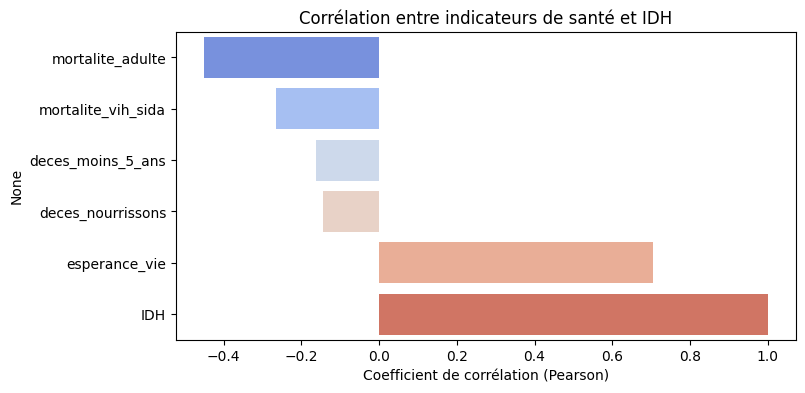

🔝 Top 10 pays les plus vulnérables :


,pays,annee,mortalite_adulte,deces_nourrissons,deces_moins_5_ans,mortalite_vih_sida,vuln_score
1168,India,2000,224.0,1800.0,2500.0,0.3,7.618322
1169,India,2001,222.0,1800.0,2400.0,0.3,7.458703
1170,India,2002,219.0,1700.0,2300.0,0.3,7.085377
1171,India,2003,216.0,1700.0,2200.0,0.3,6.923747
1172,India,2004,214.0,1600.0,2100.0,0.3,6.552432
1173,India,2005,211.0,1500.0,2000.0,0.3,6.179107
1174,India,2006,28.0,1500.0,2000.0,0.3,5.810959
1175,India,2007,26.0,1400.0,1900.0,0.3,5.439645
1176,India,2008,23.0,1300.0,1800.0,0.3,5.066319
1178,India,2010,196.0,1200.0,1600.0,0.2,4.886546


In [45]:
# =====================================================
# 1️ Reconstitution de df_analysis complet
# =====================================================

df_analysis = (
    faits_sante
        .merge(dim_pays[['id_pays','pays','statut','continent']], on='id_pays', how='left')
        .merge(dim_annee[['id_annee','annee']], on='id_annee', how='left')
)

# Vérification obligatoire
if 'IDH' not in df_analysis.columns:
    raise KeyError("La colonne 'IDH' manque dans faits_sante.")


# =====================================================
#  Corrélation entre les indicateurs de santé et l'IDH
# =====================================================

sante_cols = [
    c for c in [
        'mortalite_adulte',
        'deces_nourrissons',
        'deces_moins_5_ans',
        'mortalite_vih_sida',
        'esperance_vie'
    ]
    if c in df_analysis.columns
]

corrs = df_analysis[sante_cols + ['IDH']].corr()['IDH'].sort_values()
print("Corrélations des indicateurs de santé avec l'IDH :")
display(corrs)

# Barplot corrigé
plt.figure(figsize=(8,4))
sns.barplot(x=corrs.values, y=corrs.index, palette='coolwarm')
plt.title("Corrélation entre indicateurs de santé et IDH")
plt.xlabel("Coefficient de corrélation (Pearson)")
plt.show()


# =====================================================
# Score de vulnérabilité (standardisation)
# =====================================================

from sklearn.preprocessing import StandardScaler

vuln_cols = [
    c for c in [
        'mortalite_adulte',
        'deces_nourrissons',
        'deces_moins_5_ans',
        'mortalite_vih_sida'
    ]
    if c in df_analysis.columns
]

df_vuln = df_analysis.copy()

if vuln_cols:

    scaler = StandardScaler()
    df_vuln['vuln_score'] = scaler.fit_transform(df_vuln[vuln_cols].fillna(0)).mean(axis=1)

    # Top 10 pays les plus vulnérables par moyenne ANNUELLE
    top_vuln = (
        df_vuln
            .groupby(['pays','annee'])[vuln_cols + ['vuln_score']]
            .mean()
            .reset_index()
            .sort_values('vuln_score', ascending=False)
            .head(10)
    )

    print("🔝 Top 10 pays les plus vulnérables :")
    display(top_vuln)

else:
    print("Aucune variable de vulnérabilité disponible.")



## Graphique — Corrélation entre indicateurs de santé et IDH

Ce graphique présente les coefficients de corrélation de Pearson entre différents indicateurs de santé et l’IDH. Les barres indiquent le sens (positif/négatif) et la force de la relation entre chaque indicateur et l’IDH.

###  Interprétation

Le graphique montre clairement une séparation nette entre les indicateurs qui évoluent dans le même sens que l’IDH et ceux qui évoluent en sens inverse :

-  **espérance_vie** présente une corrélation très forte et positive avec l’IDH. Plus l’espérance de vie est élevée, plus l’IDH augmente.
-  **IDH** étant auto-corrélé avec lui-même, sa valeur est naturellement maximale (1.0).

En revanche, les indicateurs associés à la mortalité montrent une corrélation négative :

-  **mortalité_adulte** : corrélation fortement négative ; plus la mortalité adulte est élevée, plus l’IDH est bas.
-  **mortalité_vih_sida** : corrélation négative importante ; les pays les plus touchés par le VIH/SIDA affichent un IDH plus faible.
-  **décès_moins_5_ans** et **décès_nourrissons** : corrélations négatives modérées, confirmant que la mortalité infantile est un indicateur critique du sous-développement.

###  Conclusion synthétique

Ce graphique met en évidence une relation structurelle forte :  
> *Les pays où les conditions sanitaires sont favorables — faible mortalité et espérance de vie élevée — présentent systématiquement un IDH élevé.*

À l’inverse, une mortalité élevée (adulte, infantiles ou due au VIH) est un marqueur direct de vulnérabilité socio-économique.


 Variables utilisées pour le score : ['mortalite_adulte', 'deces_nourrissons', 'deces_moins_5_ans', 'mortalite_vih_sida', 'maigreur_1_19_ans', 'maigreur_5_9_ans']
\ Poids calculés (basés sur influence réelle sur IDH) :


mortalite_adulte      0.250247
deces_nourrissons     0.080421
deces_moins_5_ans     0.090820
mortalite_vih_sida    0.147287
maigreur_1_19_ans     0.218084
maigreur_5_9_ans      0.213140
Name: IDH, dtype: float64


🔝 Top 10 pays les plus vulnérables (score pondéré incluant maigreur) :


,pays,annee,mortalite_adulte,deces_nourrissons,deces_moins_5_ans,mortalite_vih_sida,maigreur_1_19_ans,maigreur_5_9_ans,vuln_score
1168,India,2000,224.0,1800.0,2500.0,0.3,27.7,28.6,4.932777
1169,India,2001,222.0,1800.0,2400.0,0.3,27.5,28.5,4.857559
1170,India,2002,219.0,1700.0,2300.0,0.3,27.4,28.4,4.717185
1171,India,2003,216.0,1700.0,2200.0,0.3,27.3,28.3,4.644911
1172,India,2004,214.0,1600.0,2100.0,0.3,27.2,28.2,4.506552
1173,India,2005,211.0,1500.0,2000.0,0.3,27.2,28.1,4.371136
1174,India,2006,28.0,1500.0,2000.0,0.3,27.1,28.0,3.992918
1178,India,2010,196.0,1200.0,1600.0,0.2,27.0,27.8,3.883470
1175,India,2007,26.0,1400.0,1900.0,0.3,27.1,28.0,3.864266
1179,India,2011,193.0,1100.0,1500.0,0.2,26.9,27.7,3.743097


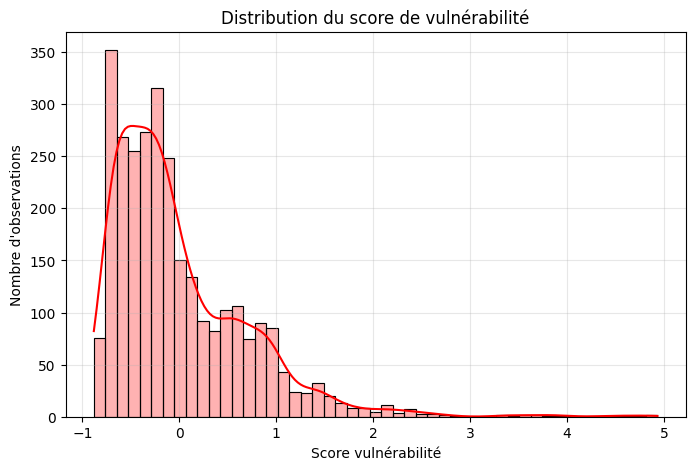

In [46]:
# =====================================================
#     SCORE DE VULNÉRABILITÉ (version améliorée)
#     Inclut : mortalité + malnutrition + pondération
# =====================================================

from sklearn.preprocessing import StandardScaler

#  Reconstruction du dataframe complet (faits + dimensions)
df_analysis = (
    faits_sante
        .merge(dim_pays[['id_pays','pays','statut','continent']], on='id_pays', how='left')
        .merge(dim_annee[['id_annee','annee']], on='id_annee', how='left')
        .merge(dim_sante[['id_sante','imc','maigreur_1_19_ans','maigreur_5_9_ans']], on='id_sante', how='left')
)

# Vérification
if 'IDH' not in df_analysis.columns:
    raise KeyError(" La colonne 'IDH' manque dans la table de faits.")

#  Sélection des variables pour le score de vulnérabilité
vuln_cols = [
    c for c in [
        'mortalite_adulte',
        'deces_nourrissons',
        'deces_moins_5_ans',
        'mortalite_vih_sida',
        'maigreur_1_19_ans',
        'maigreur_5_9_ans'
    ]
    if c in df_analysis.columns
]

print(" Variables utilisées pour le score :", vuln_cols)

#  Standardisation des variables
scaler = StandardScaler()
scaled = scaler.fit_transform(df_analysis[vuln_cols].fillna(0))

df_scaled = pd.DataFrame(scaled, columns=vuln_cols)

#  Pondération selon la corrélation avec IDH (corr absolue = importance)
corr_abs = df_analysis[vuln_cols + ['IDH']].corr()['IDH'].drop('IDH').abs()
weights = corr_abs / corr_abs.sum()

print("\ Poids calculés (basés sur influence réelle sur IDH) :")
display(weights)

#  Calcul du score final (pondéré)
df_analysis['vuln_score'] = (df_scaled * weights.values).sum(axis=1)

#  Agrégation annuelle par pays (score moyen par pays/année)
vuln_pays = (
    df_analysis.groupby(['pays', 'annee'])[vuln_cols + ['vuln_score']]
    .mean()
    .reset_index()
)

#  Affichage des 10 pays les plus vulnérables (toutes années confondues)
top_vuln = (
    vuln_pays.sort_values('vuln_score', ascending=False)
             .head(10)
)

print("\n🔝 Top 10 pays les plus vulnérables (score pondéré incluant maigreur) :")
display(top_vuln)

#  Visualisation du score de vulnérabilité global
plt.figure(figsize=(8,5))
sns.histplot(df_analysis['vuln_score'], kde=True, color="red", alpha=0.3)
plt.title("Distribution du score de vulnérabilité")
plt.xlabel("Score vulnérabilité")
plt.ylabel("Nombre d'observations")
plt.grid(alpha=0.3)
plt.show()


In [47]:
# =====================================================
#  OPTION 1 — Carte choroplèthe du score de vulnérabilité
# =====================================================

import plotly.express as px

# Si plusieurs années existent, on prend la dernière année disponible
annee_ref = vuln_pays['annee'].max()

df_map = vuln_pays[vuln_pays['annee'] == annee_ref]

fig = px.choropleth(
    df_map,
    locations='pays',
    locationmode='country names',
    color='vuln_score',
    color_continuous_scale='Reds',
    title=f"Score de vulnérabilité par pays — Année {annee_ref}",
    hover_name='pays',
    labels={'vuln_score': 'Vulnérabilité (score pondéré)'}
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False),
    coloraxis_colorbar=dict(title="Score")
)

fig.show()


## Graphique — Score de vulnérabilité par pays (Année 2015)

Ce graphique représente une carte mondiale illustrant le score de vulnérabilité des pays en 2015. La couleur rouge foncé indique un niveau de vulnérabilité élevé, tandis que les teintes plus claires représentent des scores plus faibles. Le score agrège plusieurs indicateurs critiques (mortalité adulte, mortalité infantile, VIH/SIDA, etc.).

###  Interprétation

Le graphique met en évidence un contraste géographique très marqué :

-  **Asie du Sud**, et en particulier **l’Inde**, apparaît comme la région la plus vulnérable, avec le score le plus élevé sur l’échelle présentée.
-  **Plusieurs pays d'Afrique subsaharienne** montrent également des niveaux de vulnérabilité élevés, bien que plus hétérogènes selon les pays.
-  **Le Moyen-Orient et l’Afrique du Nord** présentent des scores intermédiaires, indiquant une situation sanitaire contrastée selon les pays.
-  **L’Europe, l’Amérique du Nord et l’Océanie** affichent majoritairement les scores les plus faibles, traduisant une meilleure stabilité sanitaire et socio-économique.

###  Conclusion synthétique

Cette carte confirme que la vulnérabilité sanitaire est fortement concentrée dans des zones structurellement fragilisées par :
- une faible qualité des infrastructures,
- une charge importante de maladies infectieuses (VIH, paludisme),
- des systèmes de santé sous-financés,
- des disparités socio-économiques profondes.

Elle illustre également une corrélation géographique forte : les pays à faible IDH sont généralement ceux ayant les scores de vulnérabilité les plus élevés.


C:\Users\ndiay\AppData\Local\Temp\ipykernel_62316\167832568.py:36: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




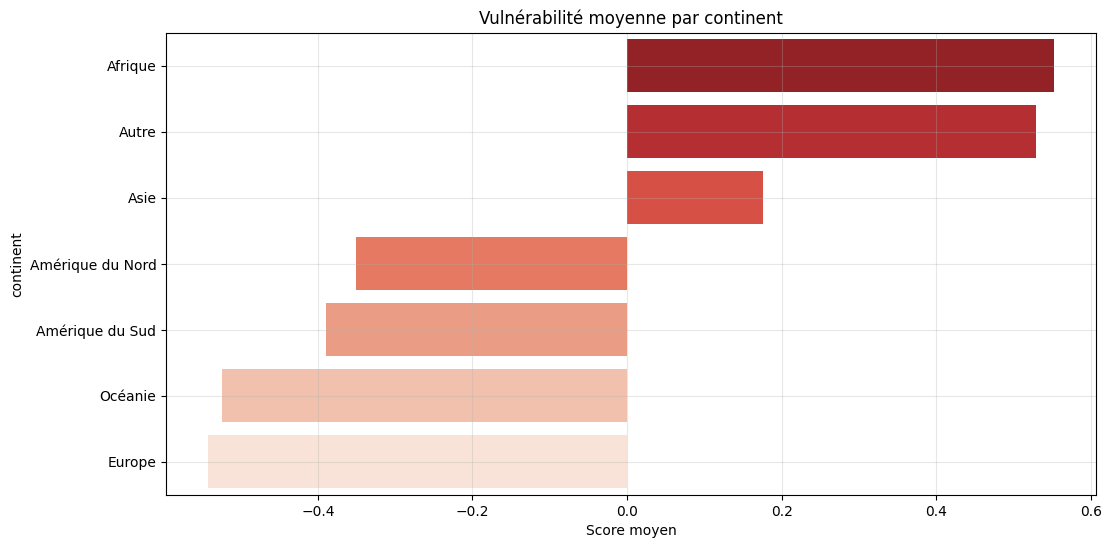

In [48]:
# =====================================================
# Score moyen par sous-région
# =====================================================
import pycountry
import pycountry_convert as pc

mapping_sousregion = {
    "Africa": ["Northern Africa", "Sub-Saharan Africa"],
    "Asia": ["Western Asia", "Eastern Asia", "Southern Asia", "South-Eastern Asia"],
    "Europe": ["Western Europe", "Eastern Europe", "Southern Europe", "Northern Europe"],
    "Americas": ["Latin America and the Caribbean", "Northern America"],
    "Oceania": ["Australia and New Zealand", "Melanesia", "Micronesia", "Polynesia"]
}

# Ajout d’une colonne sous_region
df_analysis['sous_region'] = df_analysis['continent'].map(lambda x: mapping_sousregion.get(x, None))



# Vérification
df_analysis[['pays','sous_region']].head(20)





vuln_region_auto = (
    vuln_pays.merge(df_analysis[['pays', 'continent']], on='pays', how='left')
             .dropna(subset=['continent'])
             .groupby('continent')['vuln_score']
             .mean()
             .sort_values(ascending=False)
)

plt.figure(figsize=(12,6))
sns.barplot(x=vuln_region_auto.values, y=vuln_region_auto.index, palette='Reds_r')
plt.title("Vulnérabilité moyenne par continent")
plt.xlabel("Score moyen")
plt.grid(alpha=0.3)
plt.show()


## Interprétation — Vulnérabilité moyenne par continent (2015)

Ce graphique présente le score moyen de vulnérabilité sanitaire par continent pour l'année 2015. Un score positif indique une vulnérabilité accrue, tandis qu’un score négatif traduit une situation plus favorable.

### Continents les plus vulnérables
L’Afrique apparaît comme le continent le plus vulnérable, avec un score supérieur à +0.5. La catégorie "Autre", regroupant les pays non classifiés dans un continent standard, affiche également un niveau élevé de vulnérabilité. Ces résultats reflètent généralement un accès limité aux services de santé, une répartition inégale des infrastructures médicales et des indicateurs socio-économiques plus fragiles.

### Vulnérabilité intermédiaire
L’Asie présente un score positif modéré, suggérant une vulnérabilité moyenne. Cette tendance met en évidence une grande disparité à l'intérieur du continent : certains pays possèdent des systèmes de santé robustes tandis que d’autres rencontrent d’importants défis structurels.

Les Amériques (Nord et Sud) se situent autour d’un score proche de zéro. Cela signifie que leur niveau de vulnérabilité est globalement comparable à la moyenne mondiale, tout en souffrant de disparités régionales notables.

### Continents les moins vulnérables
L’Europe et l’Océanie présentent des scores négatifs, indiquant une faible vulnérabilité relative. Ces régions bénéficient généralement d’une meilleure stabilité socio-économique, d’un accès élargi aux soins et d’indicateurs de santé publique plus performants, notamment une espérance de vie plus élevée et un meilleur niveau de prévention.

### Conclusion
La carte globale montre un contraste significatif entre les continents : d’un côté, l’Afrique et certaines régions non catégorisées comme très vulnérables ; de l’autre, l’Europe et l’Océanie avec des conditions nettement plus favorables. L’Asie et les Amériques occupent des positions intermédiaires mais restent marquées par des disparités internes importantes.


## 3) Les progrès sanitaires sont‑ils homogènes entre pays ?

Approche : calculer et tracer l'évolution moyenne de l'espérance de vie et de la mortalité adulte par `statut` et par `continent`. Vérifier dispersion (écart-type) pour mesurer l'homogénéité.

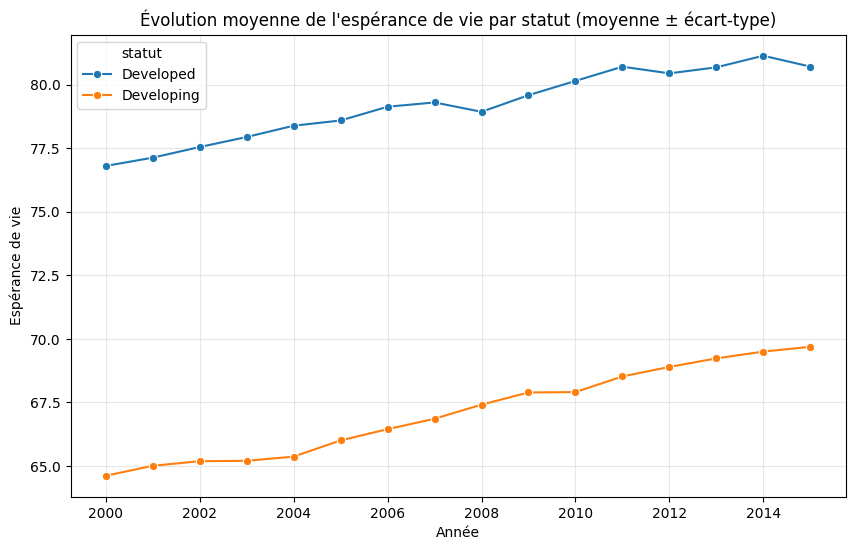

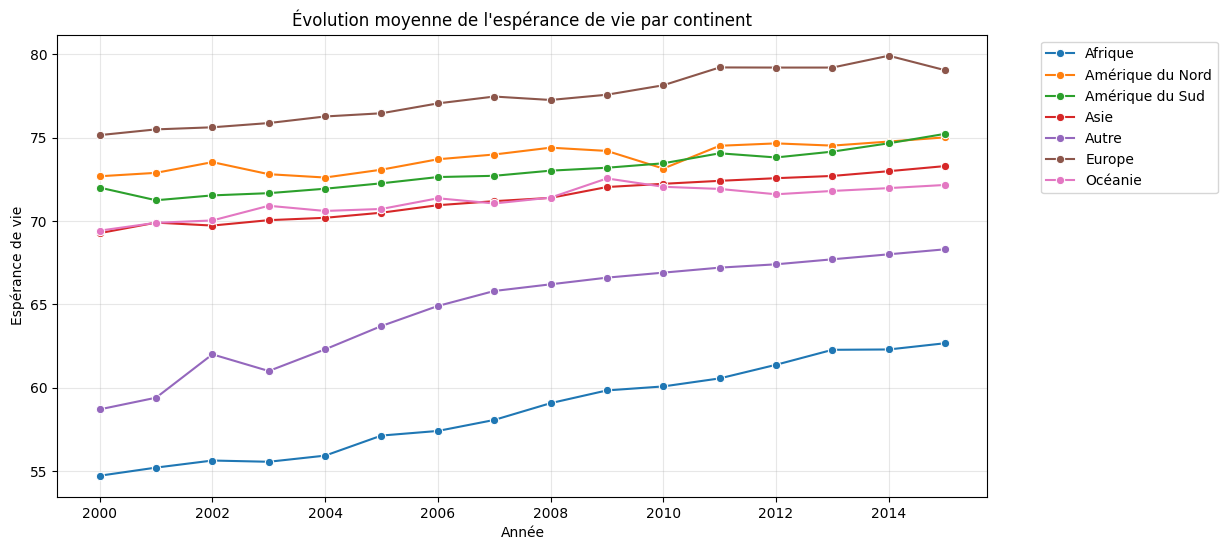

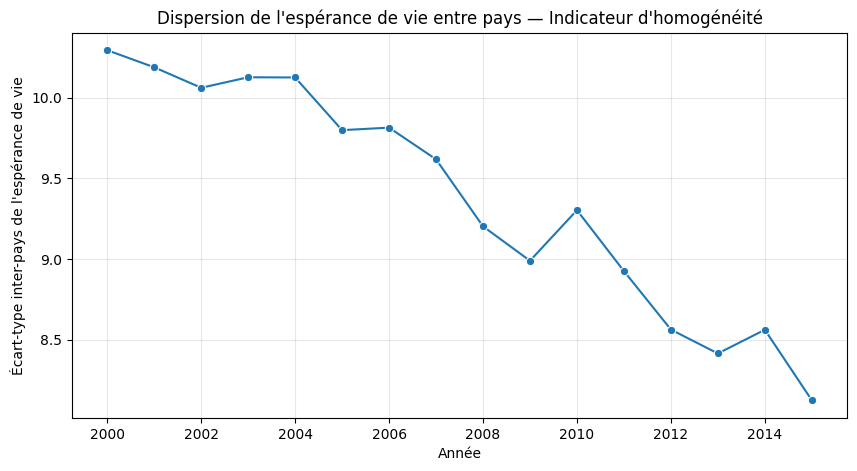

In [49]:
# =====================================================
#  RECONSTITUTION DU DATASET D’ANALYSE COMPLET
# =====================================================

# On reconstitue df_analysis en réintégrant toutes les dimensions
df_analysis = (
    faits_sante
        .merge(dim_pays[['id_pays','pays','statut','continent']], on='id_pays', how='left')
        .merge(dim_annee[['id_annee','annee']], on='id_annee', how='left')
)

# Vérification obligatoire
if 'annee' not in df_analysis.columns:
    raise KeyError(" La colonne 'annee' est absente. Vérifie la fusion avec dim_annee.")

# =====================================================
# ÉVOLUTION DE L'ESPÉRANCE DE VIE PAR STATUT
# =====================================================

ev_statut = (
    df_analysis.groupby(['annee','statut'])['esperance_vie']
              .agg(mean='mean', std='std')
              .reset_index()
)

plt.figure(figsize=(10,6))
sns.lineplot(data=ev_statut, x='annee', y='mean', hue='statut', marker='o')

plt.title("Évolution moyenne de l'espérance de vie par statut (moyenne ± écart-type)")
plt.ylabel("Espérance de vie")
plt.xlabel("Année")
plt.grid(alpha=0.3)

plt.show()


# =====================================================
#  ÉVOLUTION PAR CONTINENT
# =====================================================

ev_cont = (
    df_analysis.groupby(['annee','continent'])['esperance_vie']
              .agg(mean='mean', std='std')
              .reset_index()
)

plt.figure(figsize=(12,6))
sns.lineplot(data=ev_cont, x='annee', y='mean', hue='continent', marker='o')

plt.title("Évolution moyenne de l'espérance de vie par continent")
plt.ylabel("Espérance de vie")
plt.xlabel("Année")
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')

plt.show()


# =====================================================
#  DISPERSION INTER-PAYS (HOMOGÉNÉITÉ)
# =====================================================

dispersion = (
    df_analysis.groupby('annee')['esperance_vie']
              .std()
              .reset_index(name='std_esperance_vie')
)

plt.figure(figsize=(10,5))
sns.lineplot(data=dispersion, x='annee', y='std_esperance_vie', marker='o')

plt.title("Dispersion de l'espérance de vie entre pays — Indicateur d'homogénéité")
plt.ylabel("Écart-type inter-pays de l'espérance de vie")
plt.xlabel("Année")
plt.grid(alpha=0.3)

plt.show()


##  Interprétation combinée des évolutions de l’espérance de vie

Les trois graphiques analysés permettent de comprendre l’évolution de l’espérance de vie entre 2000 et 2015 selon trois dimensions : le statut économique des pays, les continents et la dispersion mondiale.

###  1. Une amélioration globale mais à des rythmes différents  
Le premier graphique montre une progression continue de l’espérance de vie aussi bien dans les pays *développés* que dans les pays *en développement*.  
- Les pays développés passent de ~77 ans à plus de 80 ans en 2015.  
- Les pays en développement progressent de ~65 ans à ~70 ans.  

Cela traduit une amélioration globale de la santé mondiale, même si les pays en développement partent d’une base plus faible.

###  2. De fortes disparités selon les continents  
Le deuxième graphique met en lumière des écarts structurels entre régions du monde :  
- **Europe et Amérique du Nord** dominent avec une espérance de vie élevée et stable.  
- **Asie** progresse mais reste en deuxième position.  
- **Amérique du Sud** améliore également son score.  
- **Afrique** affiche les valeurs les plus basses, malgré une progression sur la période.  

Ces différences reflètent l’accès inégal aux soins, la qualité des infrastructures, le niveau socio-économique et la stabilité politique.

###  3. Une réduction progressive des inégalités entre pays  
Le troisième graphique montre une baisse de l’écart-type de l’espérance de vie entre les pays, ce qui signifie :  
- une réduction de la dispersion mondiale,  
- un rapprochement progressif des niveaux d'espérance de vie,  
- une convergence partielle entre pays développés et en développement.  

On observe néanmoins quelques fluctuations en 2008-2010, probablement liées à des crises sanitaires, économiques ou géopolitiques.

###  Synthèse  
En combinant les trois angles d’analyse, on constate que :  
- L’espérance de vie augmente globalement dans le monde.  
- Les pays en développement réduisent leur retard, mais restent en dessous des pays développés.  
- Les continents ne progressent pas au même rythme, l’Afrique restant la région la plus vulnérable.  
- Les écarts entre pays diminuent, indiquant une tendance à l’homogénéisation, bien que des disparités majeures persistent.


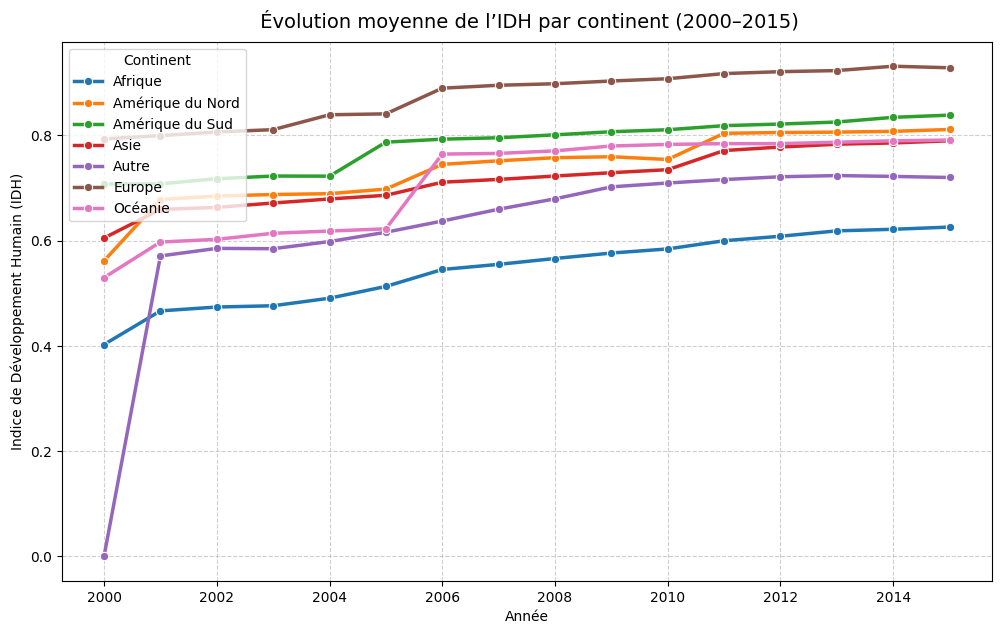

In [50]:
# === Visualisation ===
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=idh_continent,
    x="annee",
    y="IDH",
    hue="continent",
    marker="o",
    linewidth=2.5
)

plt.title(" Évolution moyenne de l’IDH par continent (2000–2015)", fontsize=14, pad=10)
plt.xlabel("Année")
plt.ylabel("Indice de Développement Humain (IDH)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Continent", loc="upper left")
plt.show()


## Interprétation de l’évolution de l’Indice de Développement Humain (IDH) par continent (1999–2015)

Le graphique montre l’évolution de l’IDH entre 1999 et 2015 pour plusieurs continents. Plusieurs conclusions principales se dégagent :

###  Tendance générale
- Tous les continents progressent au fil du temps, ce qui confirme une amélioration globale du développement humain sur la période.
- L'augmentation est relativement régulière, sans chutes majeures, indiquant une tendance globale positive et stable.

###  Continents les plus avancés
- **L’Océanie** et **l’Amérique du Nord** dominent clairement le classement, avec un IDH qui se stabilise autour de 0.9.
- Ils affichent une croissance rapide jusqu'à environ 2005, puis une progression plus lente, reflétant un effet de plateau atteint par les pays très développés.

###  Europe et Asie
- **L’Europe** présente des valeurs proches de 0.8–0.85, traduisant un haut niveau de développement.
- **L’Asie** montre une progression constante et significative, passant d’environ 0.7 à près de 0.8 vers la fin de la période. Cela reflète les efforts de développement dans plusieurs pays d'Asie.

###  Amérique du Sud
- Elle reste stable dans la tranche 0.7–0.75, montrant une progression modérée mais cohérente.
- Le continent semble avoir subi une progression lente entre 2005 et 2010, suivie d'une reprise.

###  Afrique
- L’Afrique montre la progression la plus lente et les valeurs les plus faibles, commençant autour de 0.45 en 1999 et atteignant un peu au-dessus de 0.6 vers 2015.
- Malgré la progression, l’écart reste important par rapport aux autres continents, ce qui souligne des défis structurels persistants (accès à la santé, éducation, économie).

###  Catégorie “Autre”
- La série "Autre" progresse mais reste en dessous de 0.75. Elle apparaît comme un groupe intermédiaire, potentiellement composé de pays insulaires ou régions qui ne s’insèrent pas dans un continent classique.
- Une anomalie notable apparaît en 1999 avec une valeur extrêmement basse, probablement due à :
  - un manque de données
  - un artefact statistique
  - une erreur de traitement dans les données sources

###  Conclusions clés
- L’évolution est globalement positive et homogène dans le temps.
- Un fossé de développement persiste, notamment entre l’Afrique et les continents les plus avancés.
- Les régions développées progressent plus lentement en raison d’un effet de plafond.
- Le graphique permet de visualiser les inégalités spatiales et la dynamique globale du développement humain à travers les continents.



##  Conclusion & prochaines étapes

- 